In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    MinMaxScaler,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek

# modelos de machine learning
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from lightgbm import plot_importance
from sklearn.inspection import permutation_importance

# Fórmulas e arquivos auxiliares
from src.auxiliares import dataframe_coeficientes
from src.config import DADOS_TRATADOS
from src.graficos import plot_comparar_metricas_modelos, plot_coeficientes
from src.models_imblearn import RANDOM_STATE
from src.models_imblearn import (
    grid_search_cv_classificador,
    treinar_e_validar_modelo_classificacao,
    organiza_resultados,
    metricas_grid_search
)

sns.set_theme(palette="bright")

In [2]:
df = pd.read_parquet(DADOS_TRATADOS)

df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V19,V20,V21,V23,V24,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.403993,0.251412,-0.018307,-0.110474,0.066928,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.145783,-0.069083,-0.225775,0.101288,-0.339846,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-1.232622,-0.208038,-0.108300,-0.190321,-1.175575,-0.221929,0.062723,0.061458,123.50,0
3,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.803487,0.408542,-0.009431,-0.137458,0.141267,0.502292,0.219422,0.215153,69.99,0
4,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.033194,0.084968,-0.208254,-0.026398,-0.371427,0.105915,0.253844,0.081080,3.67,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256580 entries, 0 to 256579
Data columns (total 27 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    256580 non-null  float64
 1   V1      256580 non-null  float64
 2   V2      256580 non-null  float64
 3   V3      256580 non-null  float64
 4   V4      256580 non-null  float64
 5   V5      256580 non-null  float64
 6   V6      256580 non-null  float64
 7   V7      256580 non-null  float64
 8   V8      256580 non-null  float64
 9   V9      256580 non-null  float64
 10  V10     256580 non-null  float64
 11  V11     256580 non-null  float64
 12  V12     256580 non-null  float64
 13  V14     256580 non-null  float64
 14  V16     256580 non-null  float64
 15  V17     256580 non-null  float64
 16  V18     256580 non-null  float64
 17  V19     256580 non-null  float64
 18  V20     256580 non-null  float64
 19  V21     256580 non-null  float64
 20  V23     256580 non-null  float64
 21  V24     25

#### Separação das colunas da Análise Exploratória

In [4]:
# colunas_categoricas_nao_ordenadas = []        # Não tem
# colunas_categoricas_ordenadas = []            # Não tem
# colunas_numericas_std = []                    # Colunas com distribuição normal usar o StandardScaler --> Pela grande presença de outliers nenhuma tem distribuição normal
# coluna_power_transformer = []                 # RobustScaler mais indicado para dados com grande quantidade de outliers

coluna_alvo = ["Class"]

colunas_min_max = ['Time']                # Sâo colunas que parecem ter uma distribuição uniforme

colunas_robust_scaler = [                                        # Colunas numéricas que possui distribuição assimétrica (nem uniforme e nem normal)
    coluna for coluna in df.columns if coluna not in (          
        colunas_min_max + coluna_alvo
    )
]

colunas_robust_scaler

['V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V14',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V23',
 'V24',
 'V26',
 'V27',
 'V28',
 'Amount']

In [5]:
X = df.drop(columns=coluna_alvo)
y = df[coluna_alvo]

In [6]:
y[:5]

,Class
0,0
1,0
2,0
3,0
4,0


In [7]:
y.values

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]], dtype=int64)

In [8]:
y.value_counts()[0], y.value_counts()[1]

(256088, 492)

#### Definindo os Folds para validação cruzada

In [9]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

#### Definindo Preprocessamento

In [10]:
preprocessamento = ColumnTransformer(
    transformers=[
        ('min_max', MinMaxScaler(), colunas_min_max),
        ('robust_scaler', RobustScaler(), colunas_robust_scaler),
    ]
)

#### Definindo Método de Balanceamento dos Dados

Podemos usar o RandomUnderSampler para reduzir os dados da classe majoritária, RandomOverSampler para aumentar os dados da classe minoritária, ou métodos híbridos como SMOTETomek e SMOTEENN que buscam equilibrar os dados de ambas as classes, para não gerar nem overfitting e e nem perda de informação.

In [11]:
# sampler = SMOTEENN(random_state=RANDOM_STATE)

In [12]:
sampler = RandomUnderSampler(random_state=RANDOM_STATE)      # Usando primeiramente o RandomUnderSampler para verificar resultado dos modelos de maneira mais rapida.

#### Dicionário de Classificadores

In [13]:
classificadores = {
    'DummyClassifier': {
        'classificador' : DummyClassifier(),
        'preprocessor' : None,
        'sampler': None
    },

    # modelos lineares
    'LogisticRegression': {
        'classificador' : LogisticRegression(random_state=RANDOM_STATE),
        'preprocessor' : preprocessamento,
        'sampler': sampler
    },

    # modelos de árvore de decisão
    'DecisionTree': {
        'classificador' : DecisionTreeClassifier(random_state=RANDOM_STATE),
        'preprocessor' : preprocessamento,
        'sampler': sampler
    },
    'LightGBM': {                                                                        
        'classificador' : LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1),    
        'preprocessor' : preprocessamento,
        'sampler': sampler
    },       
    'XGBoost': {
        'classificador' : XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1),
        'preprocessor' : preprocessamento,
        'sampler': sampler
    },   

    #kNN
    'KNeighboursClassifier': {
        'classificador' : KNeighborsClassifier(),
        'preprocessor' : preprocessamento,
        'sampler': sampler
    },

    #SVC
    'SVC': {
        'classificador' : SVC(random_state=RANDOM_STATE), 
        'preprocessor' : preprocessamento,
        'sampler': sampler
    },   
}

#### Treinando e Testando Modelos de Classificação

In [14]:
resultados = {nome_modelo: treinar_e_validar_modelo_classificacao(X, y, kf, **modelo) 
              for nome_modelo, modelo in classificadores.items()}

df_resultados = organiza_resultados(resultados)

df_resultados

c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c

,model,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
0,DummyClassifier,0.150815,0.320571,0.99809,0.5,0.0,0.0,0.0,0.5,0.00191,0.471386
1,DummyClassifier,0.143491,0.28359,0.99809,0.5,0.0,0.0,0.0,0.5,0.00191,0.427081
2,DummyClassifier,0.120314,0.349575,0.99809,0.5,0.0,0.0,0.0,0.5,0.00191,0.469889
3,DummyClassifier,0.136137,0.278215,0.998071,0.5,0.0,0.0,0.0,0.5,0.001929,0.414351
4,DummyClassifier,0.127782,0.288372,0.998071,0.5,0.0,0.0,0.0,0.5,0.001929,0.416154
5,LogisticRegression,0.944996,0.393004,0.97492,0.941606,0.121502,0.065106,0.908163,0.984557,0.639784,1.338
6,LogisticRegression,0.890471,0.366292,0.973108,0.955975,0.117647,0.062756,0.938776,0.984696,0.795519,1.256763
7,LogisticRegression,1.033801,0.394343,0.967593,0.94812,0.098645,0.052089,0.928571,0.978148,0.824363,1.428144
8,LogisticRegression,1.000345,0.416045,0.976304,0.937722,0.12769,0.068726,0.89899,0.977909,0.614002,1.416389
9,LogisticRegression,0.902197,0.431337,0.978058,0.958763,0.141768,0.076669,0.939394,0.986119,0.728779,1.333534


**Qual métrica vamos escolher para a melhor para esse contexto?**
- Contexto: Queremos conseguir identificar as fraudes de um cartão de crédito
- Nessa aplicação é pior não detectar um frande de um cartão do que detectar uma transação verdadeira como fraude, pois podemos ter algum método de verificação com o cliente antes de alguma compra suspeita
- Portanto, para esse problema o recall é mais importante que a precisão.
- Mas focar somente no recall pode trazer modelos que apontam tudo como fraude, o que é ruim também.
- Métricas como average_precision, que é a área de baixo da curva Precision-Recall, fazem um balanceamento entre os dados de recall e precisão e podem ser mais úteis nesse contexto.

In [15]:
df_resultados.groupby(by='model').mean().sort_values(by='test_average_precision', ascending=True)

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.135708,0.304064,0.998082,0.5,0.0,0.0,0.0,0.5,0.001918,0.439772
DecisionTree,1.026074,0.433543,0.917663,0.917171,0.04125,0.021104,0.916677,0.917171,0.019511,1.459617
KNeighboursClassifier,0.71538,8.053648,0.976011,0.944344,0.130772,0.070581,0.912554,0.975066,0.267092,8.769028
LogisticRegression,0.954362,0.400204,0.973996,0.948437,0.12145,0.065069,0.922779,0.982286,0.720489,1.354566
SVC,0.522156,4.044885,0.985077,0.936746,0.190477,0.107136,0.888229,0.985302,0.728365,4.56704
LightGBM,2.024256,0.779373,0.972476,0.952726,0.116662,0.062304,0.9329,0.98645,0.752274,2.803629
XGBoost,1.095305,0.431988,0.968478,0.95275,0.10331,0.054705,0.936961,0.985594,0.764235,1.527293


**Análise dos Resultados**
- Melhores modelos: XGBClassifier e LightGBM
- Além de bons resultados da average_precision, outras métricas parecem ser muito boas também (recall, precision, roc_auc)

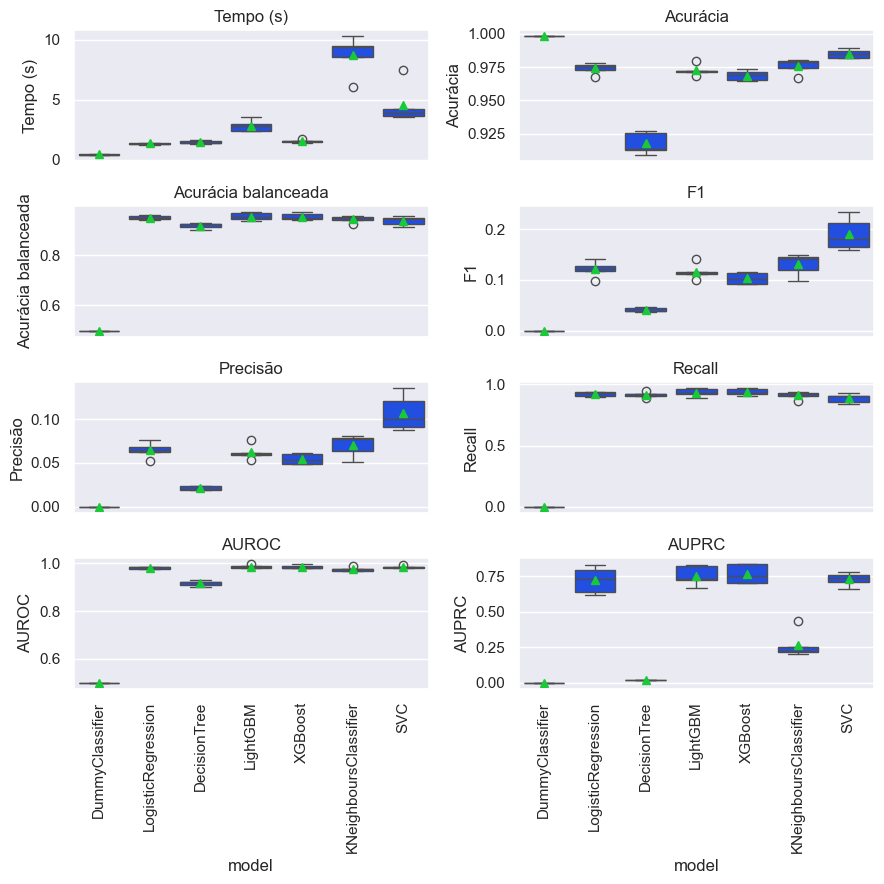

In [16]:
plot_comparar_metricas_modelos(df_resultados)

#### Escolher modelo para otimização: *LightGBM*
- Os melhores modelos foram XGBoost e LightGBM olhando pro Recall (93% ambos).
- Mas o LightGBM apresentou maior precisão (63%) perando o XGBoost (54%)
- Ambos modelos apresentam a métrica average_precision parecidos (75% do LightGBM e 76% do XGBoost)
- Será escolhido o modelo LightGBM para otimização dos resultados, e num notebook posterior iremos utilizar o XGBoost, para poder comparar os resultados dos 2 modelos otimizados.

#### Testando diferentes parâmetros no melhor modelo

In [17]:
y.value_counts()[0], y.value_counts()[1]

(256088, 492)

In [18]:
scale_pos_weight = y.value_counts()[0] / y.value_counts()[1]
scale_pos_weight

520.5040650406504

In [19]:
param_grid = {
    "clf__max_depth": [3, 6],                       # Profundidade máxima da árvore (<=0 significa sem limite)
    "clf__num_leaves": [10, 20],                    # Número máximo de folhas por árvore --> Isso no LGBM acaba crescendo mais, e por conta disso temos valores maiores
    # "clf__min_child_samples": [10, 20, 50],       # Mínimo de amostras em um nó folha
    # "clf__min_split_gain": [0.0, 0.1, 0.3],       # Redução mínima de perda para divisão
    "clf__subsample": [0.75, 1.0],                  # Proporção de amostras usadas para cada árvore
    "clf__colsample_bytree": [0.75, 1.0],           # Proporção de features para construção de cada árvore
    "clf__learning_rate": [0.05, 0.1],              # Taxa de aprendizado
    #"clf__n_estimators": [10, 50],                 # Número de árvores
    "clf__reg_alpha": [1, 2, 5],                    # Regularização L1
    "clf__reg_lambda": [0.0, 0.5, 1.0],             # Regularização L2
    #"clf__scale_pos_weight": [1, scale_pos_weight], # Peso das classes (base já está balanceada com RandomUnderSampler)
}

#### Rodando a função do GridSearchCV

In [20]:
sampler

RandomUnderSampler(random_state=42)

In [21]:
clf = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)

grid_search = grid_search_cv_classificador(
    clf,
    param_grid=param_grid,
    cv=kf,
    preprocessor=preprocessamento,
    refit_metric='average_precision',
    sampler=sampler
)

grid_search

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('min_max',
                                                                         MinMaxScaler(),
                                                                         ['Time']),
                                                                        ('robust_scaler',
                                                                         RobustScaler(),
                                                                         ['V1',
                                                                          'V2',
                                                                          'V3',
                                                                          'V4',
                                                                          'V5',
                                                                          'V6',
                                                                          'V7',
                                                                          'V8',
                                                                          'V9',
                                                                          'V10',
                                                                          'V11',
                                                                          'V12',
                                                                          'V14',
                                                                          'V16',
                                                                          'V17',
                                                                          'V18',
                                                                          'V19',
                                                                          'V20',
                                                                          'V21',
                                                                          'V23',
                                                                          'V24',
                                                                          'V26',
                                                                          'V27',
                                                                          'V28'...
             n_jobs=-1,
             param_grid={'clf__colsample_bytree': [0.75, 1.0],
                         'clf__learning_rate': [0.05, 0.1],
                         'clf__max_depth': [3, 6], 'clf__num_leaves': [10, 20],
                         'clf__reg_alpha': [1, 2, 5],
                         'clf__reg_lambda': [0.0, 0.5, 1.0],
                         'clf__subsample': [0.75, 1.0]},
             refit='average_precision',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [ ]:
grid_search.fit(X,y)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


In [ ]:
grid_search.best_score_            

0.7480789543226944

**Análise do best_score_**: 
- Aumentou de 0.752 no modelo simples do LightGBM para 0.779 (2.7% a mais)

In [ ]:
grid_search.best_params_

{'clf__colsample_bytree': 0.75,
 'clf__learning_rate': 0.1,
 'clf__max_depth': 3,
 'clf__n_estimators': 50,
 'clf__num_leaves': 10,
 'clf__reg_alpha': 1,
 'clf__reg_lambda': 0.5,
 'clf__subsample': 0.75}

#### Obtendo as Outras Métricas do grid_search.best_estimator

In [ ]:
metricas_grid_search(grid_search)

# OBS: Recall manteve-se em 93%

mean_fit_time: 6.106488990783691
mean_score_time: 0.636664628982544
mean_test_accuracy: 0.9749278977317015
mean_test_balanced_accuracy: 0.9499013075247225
mean_test_f1: 0.12575878563128967
mean_test_precision: 0.06755567513691027
mean_test_recall: 0.9247783962069676
mean_test_roc_auc: 0.985893918038904
mean_test_average_precision: 0.7480789543226944


#### Analisando as features de maior importância pro modelo

*Métodos que serão utilizados:*
- Permutation Importance: com parametros 'weight''
- Permutation Importance: com parametros 'gain'
- Plot Importance

##### Permutation Importance

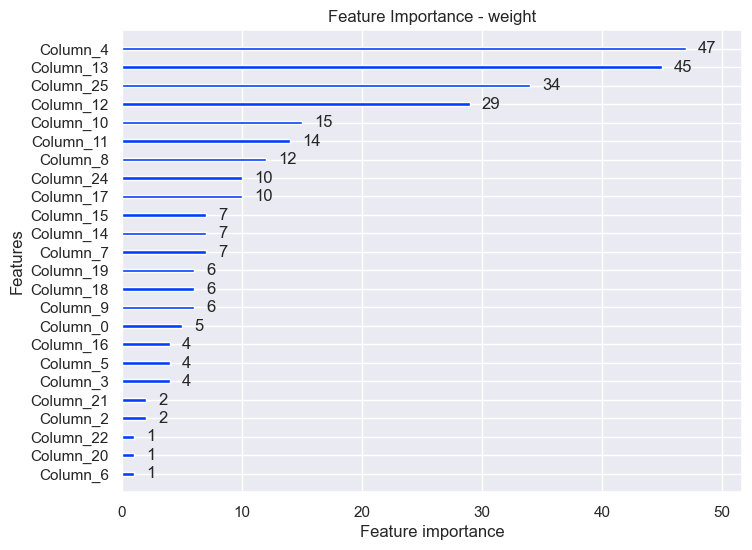

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))

plot_importance(
    grid_search.best_estimator_['clf'],
    ax=ax, 
    title = 'Feature Importance - weight'
)

plt.show()

In [ ]:
feature_names = grid_search.best_estimator_["preprocessor"].get_feature_names_out()
feature_names

array(['min_max__Time', 'robust_scaler__V1', 'robust_scaler__V2',
       'robust_scaler__V3', 'robust_scaler__V4', 'robust_scaler__V5',
       'robust_scaler__V6', 'robust_scaler__V7', 'robust_scaler__V8',
       'robust_scaler__V9', 'robust_scaler__V10', 'robust_scaler__V11',
       'robust_scaler__V12', 'robust_scaler__V14', 'robust_scaler__V16',
       'robust_scaler__V17', 'robust_scaler__V18', 'robust_scaler__V19',
       'robust_scaler__V20', 'robust_scaler__V21', 'robust_scaler__V23',
       'robust_scaler__V24', 'robust_scaler__V26', 'robust_scaler__V27',
       'robust_scaler__V28', 'power_transform__Amount'], dtype=object)

In [ ]:
importancia_features = grid_search.best_estimator_['clf'].booster_.feature_importance()    # A coluna 0 tem 11 aparições nas árvores, a coluna 1 tem 14, a coluna 2 tem 1 ....
importancia_features

array([ 5,  0,  2,  4, 47,  4,  1,  7, 12,  6, 15, 14, 29, 45,  7,  7,  4,
       10,  6,  6,  1,  2,  1,  0, 10, 34])

In [ ]:
indices_features = np.argsort(importancia_features)[::-1]
indices_features

array([ 4, 13, 25, 12, 10, 11,  8, 17, 24,  7, 15, 14,  9, 19, 18,  0, 16,
        5,  3,  2, 21, 20, 22,  6, 23,  1], dtype=int64)

In [ ]:
sorted_feature_names = feature_names[indices_features]
sorted_feature_names

array(['robust_scaler__V4', 'robust_scaler__V14',
       'power_transform__Amount', 'robust_scaler__V12',
       'robust_scaler__V10', 'robust_scaler__V11', 'robust_scaler__V8',
       'robust_scaler__V19', 'robust_scaler__V28', 'robust_scaler__V7',
       'robust_scaler__V17', 'robust_scaler__V16', 'robust_scaler__V9',
       'robust_scaler__V21', 'robust_scaler__V20', 'min_max__Time',
       'robust_scaler__V18', 'robust_scaler__V5', 'robust_scaler__V3',
       'robust_scaler__V2', 'robust_scaler__V24', 'robust_scaler__V23',
       'robust_scaler__V26', 'robust_scaler__V6', 'robust_scaler__V27',
       'robust_scaler__V1'], dtype=object)

In [ ]:
len(feature_names), len(importancia_features), len(sorted_feature_names)

(26, 26, 26)

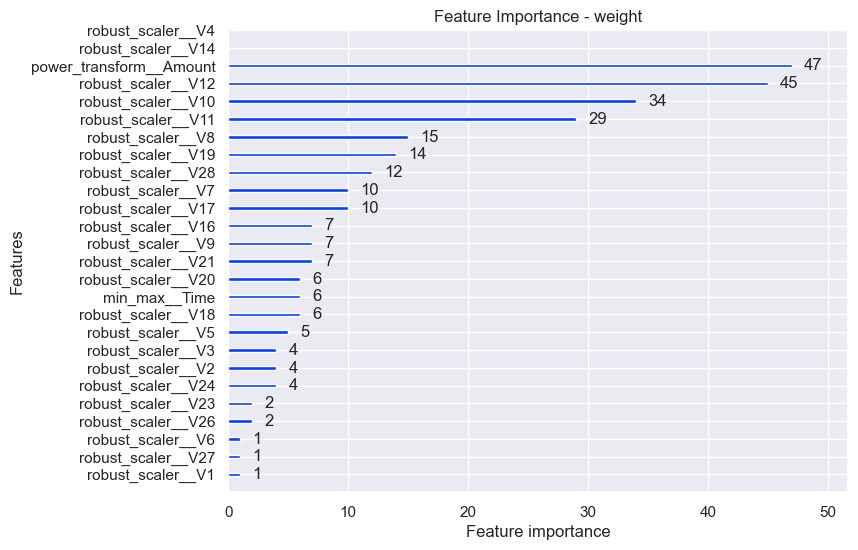

In [ ]:
from lightgbm import plot_importance

fig, ax = plt.subplots(figsize=(8,6))

plot_importance(
    grid_search.best_estimator_['clf'],
    ax=ax, 
    title = 'Feature Importance - weight',
    max_num_features=len(feature_names),
)

plt.yticks(
    np.arange(len(grid_search.best_estimator_['preprocessor'].get_feature_names_out())),            # Quantidade de ticks
    sorted_feature_names[::-1]                                                                           # Nome de cada ticks
)

plt.show()

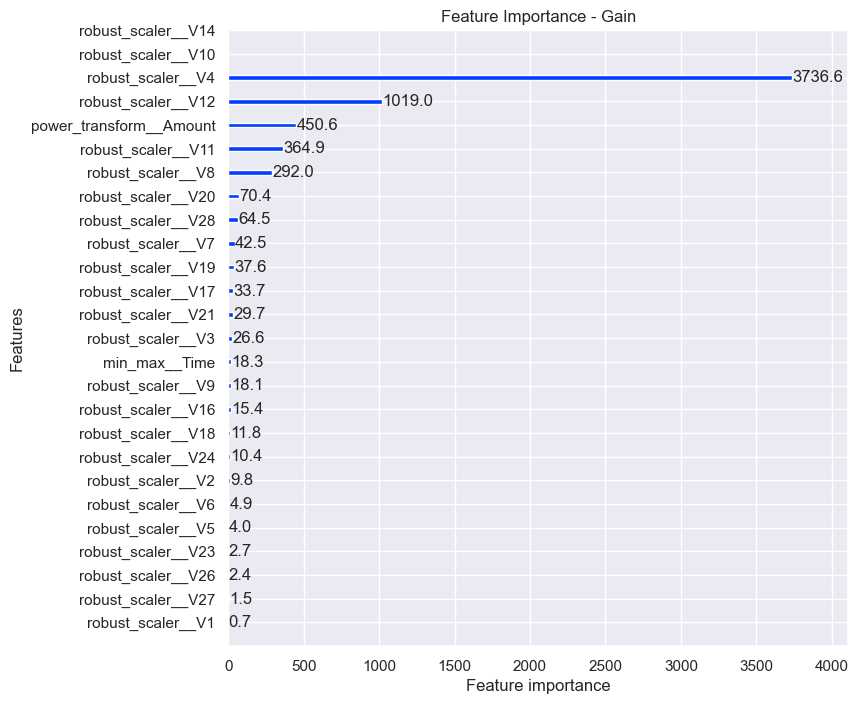

In [ ]:
indices_gain = grid_search.best_estimator_['clf'].booster_.feature_importance('gain').argsort()

fig, ax = plt.subplots(figsize=(8,8))

plot_importance(
    grid_search.best_estimator_['clf'],
    ax=ax, 
    importance_type='gain',
    title = 'Feature Importance - Gain',
    precision=1
)

plt.yticks(
    np.arange(len(grid_search.best_estimator_['preprocessor'].get_feature_names_out())),            # Quantidade de ticks
    grid_search.best_estimator_['preprocessor'].get_feature_names_out()[indices_gain]               # Nome de cada ticks
)

plt.show()

##### Permutation Importance

In [ ]:
perm_imp = permutation_importance(
    grid_search.best_estimator_,
    X,
    y,
    n_repeats=10,
    random_state=RANDOM_STATE
)

c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature nam

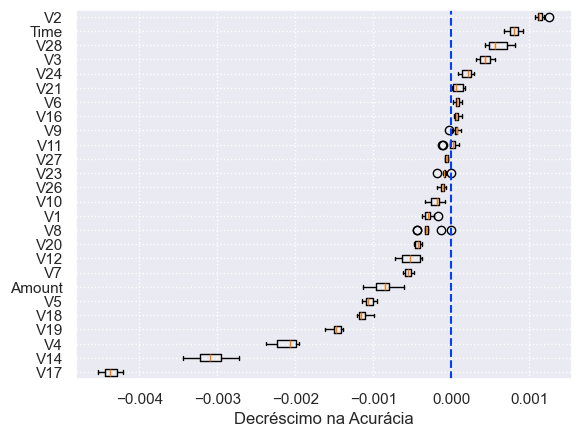

In [ ]:
fig, ax = plt.subplots()

ordem = perm_imp.importances_mean.argsort()

ax.boxplot(perm_imp.importances[ordem].T, vert=False, tick_labels=X.columns[ordem])
ax.axvline(x=0, linestyle="--")
ax.set_xlabel("Decréscimo na Acurácia")
ax.grid(True, linestyle=":")

plt.show()

#### Matriz de Confusão

c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


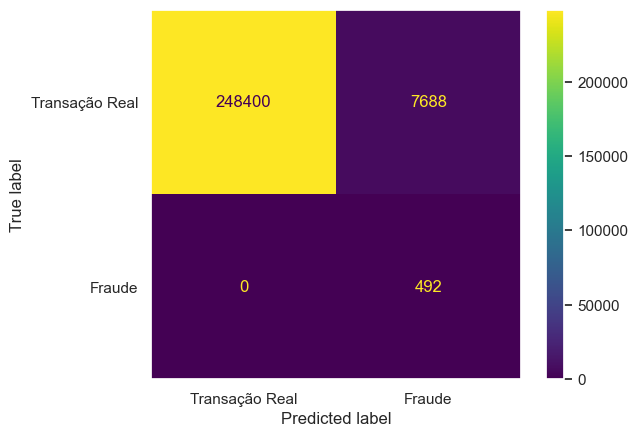

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels = ['Transação Real', 'Fraude']
)

plt.grid(False)
plt.show()

c:\Users\brcprrcchave\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


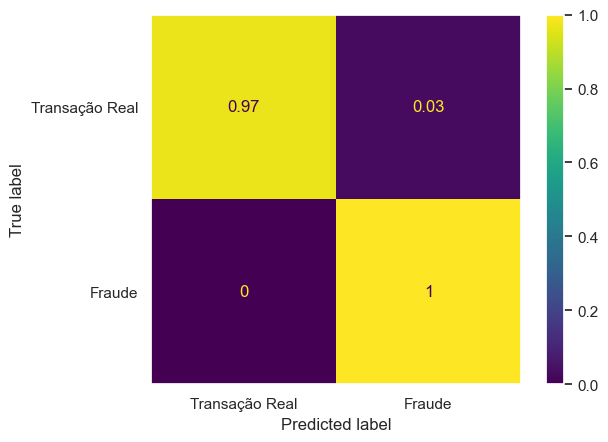

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    grid_search.best_estimator_,
    X,
    y,
    display_labels = ['Transação Real', 'Fraude'],
    normalize='true'
)

plt.grid(False)
plt.show()

##### **Conclusões**
- Não sabemos o que cada feature representa, mas ao utilizar 3 métodos para analisar as features de maior importância vemos que as colunas "V14, V4, V12, V17" e o valor da transação "Amount" se repetem demonstrando uma influência maior na detecção de fraudes do cartão de crédito.
- Resultados válidos para o modelo LGBMClassifier da biblioteca LightGBM considerando balanceamento das classes pelo RandomUnderSampler 